# Active Learning with Visualization
This notebook demonstrates the application of active learning strategies to improve model accuracy by selectively labeling data.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


In [2]:

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target

# Standardize the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initial split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:

# Define the Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x


In [4]:

# Define uncertainty sampling for active learning
def uncertainty_sampling(model, X_pool, n_samples):
    model.eval()
    with torch.no_grad():
        X_pool_tensor = torch.FloatTensor(X_pool)
        probs = model(X_pool_tensor)
        uncertainties = 1 - torch.max(probs, dim=1).values.numpy()
    selected_indices = np.argsort(uncertainties)[-n_samples:]
    return selected_indices

# Define random sampling for active learning
def random_sampling(X_pool, n_samples):
    return np.random.choice(len(X_pool), size=n_samples, replace=False)


In [5]:

# Active Learning Loop
input_size = X_train.shape[1]
num_classes = len(set(y))
model = NeuralNetwork(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initial labeled data
initial_indices = np.random.choice(len(X_train), size=10, replace=False)
X_labeled = X_train[initial_indices]
y_labeled = y_train[initial_indices]
X_pool = np.delete(X_train, initial_indices, axis=0)
y_pool = np.delete(y_train, initial_indices, axis=0)

# Track accuracy over iterations
accuracies = []
samples = []

for iteration in range(5):  # 5 iterations of active learning
    # Convert labeled data to tensors
    X_labeled_tensor = torch.FloatTensor(X_labeled)
    y_labeled_tensor = torch.LongTensor(y_labeled)

    # Train the model
    for epoch in range(20):  # Shorter training for each iteration
        model.train()
        optimizer.zero_grad()
        outputs = model(X_labeled_tensor)
        loss = criterion(outputs, y_labeled_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.LongTensor(y_test)
        y_pred_probs = model(X_test_tensor)
        y_pred = torch.argmax(y_pred_probs, axis=1).numpy()
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        samples.append(len(X_labeled))

    # Select new samples to label using uncertainty sampling

    selected_indices = uncertainty_sampling(model, X_pool, n_samples=5)
    X_labeled = np.vstack((X_labeled, X_pool[selected_indices]))
    y_labeled = np.hstack((y_labeled, y_pool[selected_indices]))
    X_pool = np.delete(X_pool, selected_indices, axis=0)
    y_pool = np.delete(y_pool, selected_indices, axis=0)


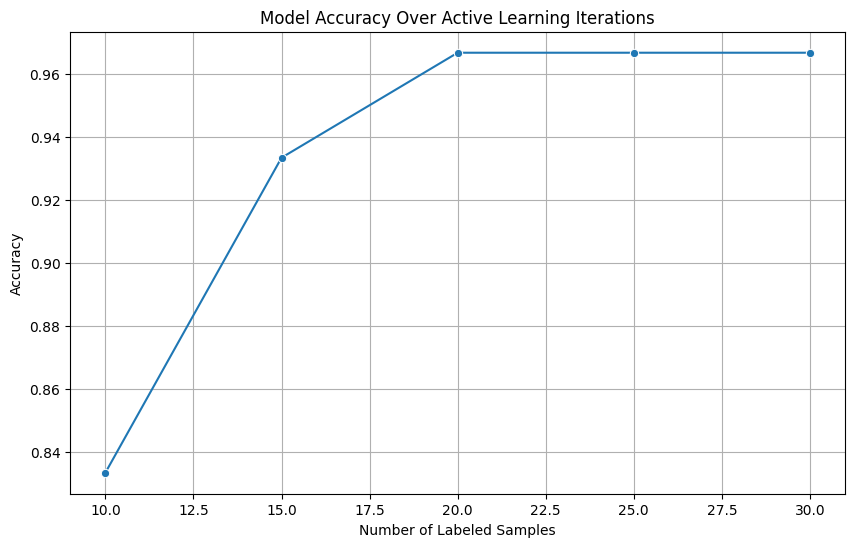

In [6]:

# Plot accuracy over iterations
plt.figure(figsize=(10, 6))
sns.lineplot(x=samples, y=accuracies, marker='o')
plt.title('Model Accuracy Over Active Learning Iterations')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


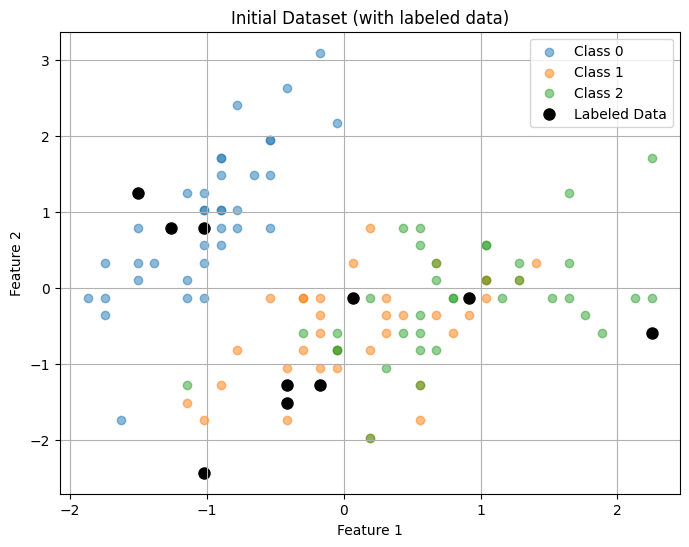

In [7]:

# Visualize the initial dataset
def plot_data(X, y, labeled_indices=None, title='Dataset Visualization'):
    plt.figure(figsize=(8, 6))
    for class_value in np.unique(y):
        plt.scatter(X[y == class_value, 0], X[y == class_value, 1], label=f'Class {class_value}', alpha=0.5)
    if labeled_indices is not None:
        plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c='black', label='Labeled Data', edgecolor='white', s=100)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Initial visualization of the dataset
plot_data(X_train, y_train, initial_indices, title='Initial Dataset (with labeled data)')


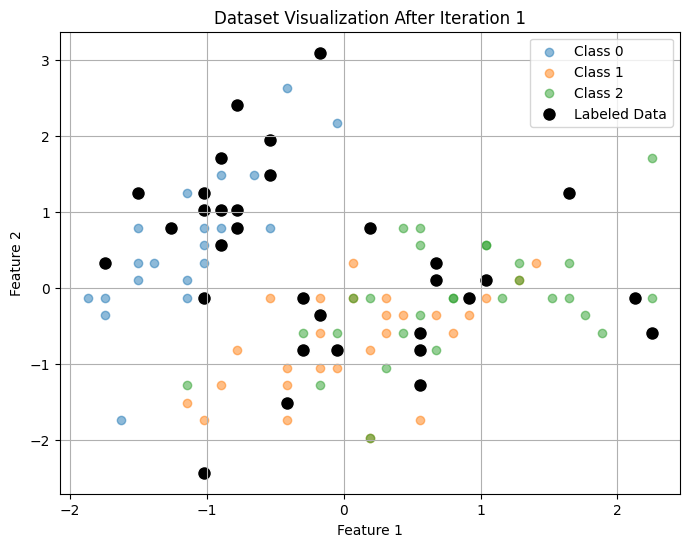

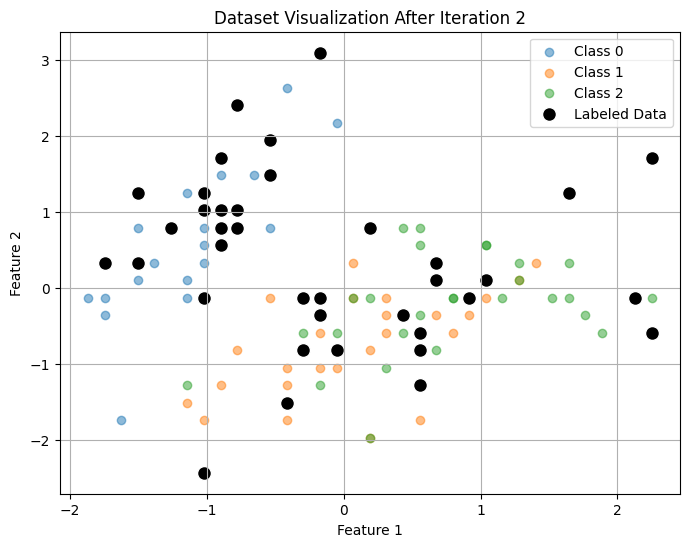

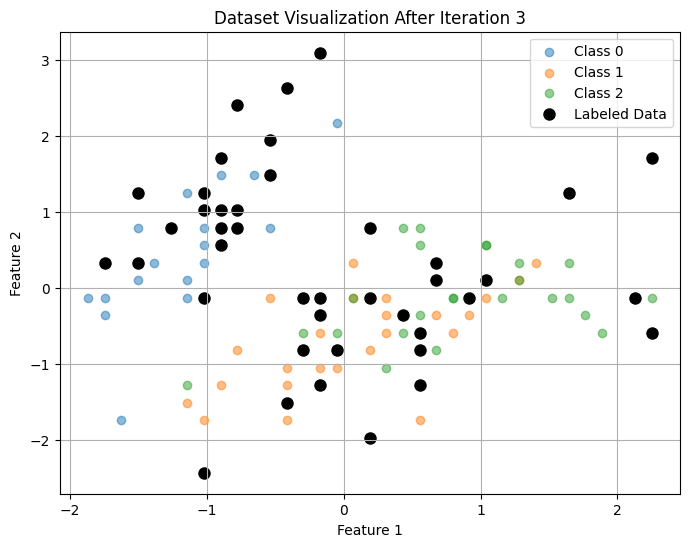

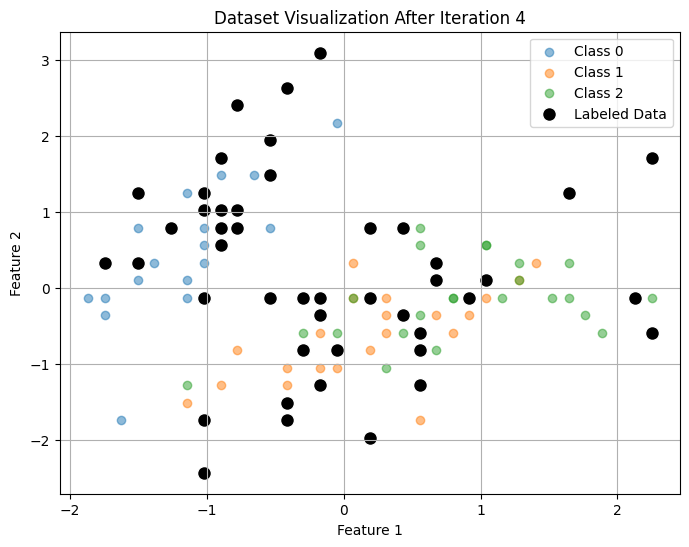

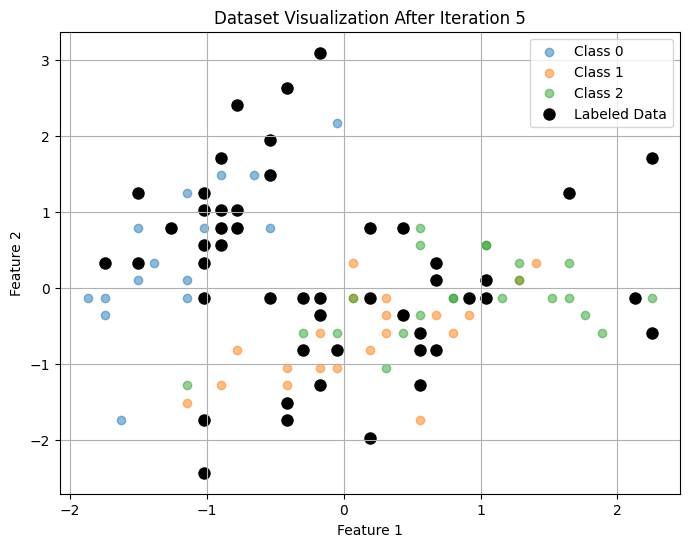

In [8]:

# Active Learning Loop with Visualization
accuracies = []
samples = []

for iteration in range(5):  # 5 iterations of active learning
    # Convert labeled data to tensors
    X_labeled_tensor = torch.FloatTensor(X_labeled)
    y_labeled_tensor = torch.LongTensor(y_labeled)

    # Train the model
    for epoch in range(20):  # Shorter training for each iteration
        model.train()
        optimizer.zero_grad()
        outputs = model(X_labeled_tensor)
        loss = criterion(outputs, y_labeled_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.LongTensor(y_test)
        y_pred_probs = model(X_test_tensor)
        y_pred = torch.argmax(y_pred_probs, axis=1).numpy()
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        samples.append(len(X_labeled))

    # Visualize the dataset after adding new samples
    labeled_indices = np.arange(len(X_labeled))  # All labeled indices in X_labeled
    plot_data(X_train, y_train, labeled_indices=labeled_indices, title=f'Dataset Visualization After Iteration {iteration + 1}')

    # Select new samples to label using uncertainty sampling
    selected_indices = uncertainty_sampling(model, X_pool, n_samples=5)
    X_labeled = np.vstack((X_labeled, X_pool[selected_indices]))
    y_labeled = np.hstack((y_labeled, y_pool[selected_indices]))
    X_pool = np.delete(X_pool, selected_indices, axis=0)
    y_pool = np.delete(y_pool, selected_indices, axis=0)
